In [118]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import cvxpy as cp
from sklearn.covariance import LedoitWolf
import warnings
warnings.filterwarnings('ignore')

In [119]:
def read_asset_data(file_path, asset_name):
    """
    Reads asset data from a CSV file and returns a DataFrame with columns:
    - date
    - price
    - volume
    - asset
    """
    # Read CSV file
    df = pd.read_csv(file_path)
    
    # Ensure the required columns are present
    required_columns = ['date', 'price', 'volume']
    if not all(col in df.columns for col in required_columns):
        print(f"CSV file {file_path} is missing one of the required columns: {required_columns}")
        return pd.DataFrame()
    
    # Convert 'date' column to datetime
    df['date'] = pd.to_datetime(df['date'])
    
    # Convert 'price' and 'volume' to numeric
    df['price'] = pd.to_numeric(df['price'], errors='coerce')
    df['volume'] = pd.to_numeric(df['volume'], errors='coerce')
    
    # Drop rows with NaNs in 'price' or 'volume'
    df = df.dropna(subset=['date', 'price', 'volume'])
    
    # Add 'asset' column
    df['asset'] = asset_name
    
    # Sort by date
    df = df.sort_values('date').reset_index(drop=True)
    
    return df
def calculate_returns(df):
    """
    Calculate daily returns from price data, with forward filling for missing prices.
    """
    df = df.sort_values('date')
    # Forward-fill missing prices
    df['price'] = df['price'].fillna(method='ffill')
    # Drop any remaining NaN values (if the first price is NaN)
    df = df.dropna(subset=['price'])
    df['return'] = df['price'].pct_change()
    df = df.dropna(subset=['return'])
    return df
def compute_covariance_matrix(returns):
    """
    Compute the covariance matrix using the Ledoit-Wolf shrinkage estimator.
    """
    lw = LedoitWolf().fit(returns)
    cov_matrix = pd.DataFrame(lw.covariance_, index=returns.columns, columns=returns.columns)
    return cov_matrix

In [120]:
def optimize_portfolio(returns, target_return, cov_matrix, median_volumes, M, f_i):
    """
    Optimize the portfolio weights using the LIBRO approach with liquidity constraints.
    """
    assets = returns.columns.tolist()
    num_assets = len(assets)
    w = cp.Variable(num_assets)
    expected_returns = returns.mean().values
    portfolio_return = expected_returns @ w
    portfolio_variance = cp.quad_form(w, cov_matrix.values)
    
    # Liquidity constraints
    TV_i_median = median_volumes.loc[assets].values
    a_i = (f_i * TV_i_median) / M
    
    constraints = [
        cp.sum(w) == 1,
        w >= 0,
        w <= a_i,  # Liquidity constraints
        portfolio_return >= target_return
    ]
    
    objective = cp.Minimize(portfolio_variance)
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.SCS)
    
    if problem.status not in ["optimal", "optimal_inaccurate"]:
        print("Optimization problem did not converge.")
        return None
    
    weights = pd.Series(w.value, index=assets)
    return weights

In [121]:
import datetime

# Investment amount
M = 100_000_000  # $100 million

# Liquidity factor
f_i = 0.01  # 1% of median trading volume

# Date range
start_date = datetime.date(2020, 12, 28)
end_date = datetime.date(2021, 12, 31)

# List of assets with their corresponding CSV file paths

# Crypto assets
crypto_assets = {
    'BTC': 'Data/Crypto/BTC.csv',
    'ETH': 'Data/Crypto/ETH.csv',
    'BNB': 'Data/Crypto/BNB.csv',
    'XRP': 'Data/Crypto/XRP.csv',
    'ADA': 'Data/Crypto/ADA.csv',
    'DOGE': 'Data/Crypto/DOGE.csv',
    'SOL': 'Data/Crypto/SOL.csv',
    'TON': 'Data/Crypto/TON.csv',
    'TRX': 'Data/Crypto/TRX.csv',
    'AVAX': 'Data/Crypto/AVAX.csv',
}

# Stock assets
stock_assets = {
    'AAPL': 'DATA/S&P500/AAPL.csv',
    'MSFT': 'DATA/S&P500/MSFT.csv',
    'AMZN': 'DATA/S&P500/AMZN.csv',
    'GOOGL': 'DATA/S&P500/GOOGL.csv',
    'TSLA': 'DATA/S&P500/TSLA.csv',
    'META': 'DATA/S&P500/META.csv',
    'NVDA': 'DATA/S&P500/NVDA.csv',
    'VST': 'DATA/S&P500/VST.csv',
    'CEG': 'DATA/S&P500/CEG.csv',
    'PLTR': 'DATA/S&P500/PLTR.csv',
    'HWM': 'DATA/S&P500/HWM.csv',
    'GE': 'DATA/S&P500/GE.csv',
    'NRG': 'DATA/S&P500/NRG.csv',
    'TRGP': 'DATA/S&P500/TRGP.csv',
    'IRM': 'DATA/S&P500/IRM.csv',
}

# ETF assets
etf_assets = {
    'FNGU': 'DATA/ETFS/FNGU.csv',
    'FTEC': 'DATA/ETFS/FTEC.csv',
    'SMH': 'DATA/ETFS/SMH.csv',
    'TECL': 'DATA/ETFS/TECL.csv',
    'TQQQ': 'DATA/ETFS/TQQQ.csv',
    'USD': 'DATA/ETFS/USD.csv',
    'ESGU': 'DATA/ETFS/ESGU.csv',  
    'GLD': 'DATA/ETFS/GLD.csv',   
    'IYT': 'DATA/ETFS/IYT.csv',    
    'QQQ': 'DATA/ETFS/QQQ.csv',   
    'SUSA': 'DATA/ETFS/SUSA.csv',  
    'VGT': 'DATA/ETFS/VGT.csv',   
    'VHT': 'DATA/ETFS/VHT.csv',    
    'VPU': 'DATA/ETFS/VPU.csv',    
    'XLK': 'DATA/ETFS/XLK.csv',   
}

In [122]:
# Read cryptocurrency data
crypto_data_list = []
for asset_name, file_path in crypto_assets.items():
    print(f"Reading data for {asset_name} from {file_path}...")
    df = read_asset_data(file_path, asset_name)
    if not df.empty:
        crypto_data_list.append(df)

crypto_data = pd.concat(crypto_data_list, ignore_index=True)

# Read stock and ETF data
stock_data_list = []
all_assets = {**stock_assets, **etf_assets}
for asset_name, file_path in all_assets.items():
    print(f"Reading data for {asset_name} from {file_path}...")
    df = read_asset_data(file_path, asset_name)
    if not df.empty:
        stock_data_list.append(df)

stock_data = pd.concat(stock_data_list, ignore_index=True)

Reading data for BTC from Data/Crypto/BTC.csv...
Reading data for ETH from Data/Crypto/ETH.csv...
Reading data for BNB from Data/Crypto/BNB.csv...
Reading data for XRP from Data/Crypto/XRP.csv...
Reading data for ADA from Data/Crypto/ADA.csv...
Reading data for DOGE from Data/Crypto/DOGE.csv...
Reading data for SOL from Data/Crypto/SOL.csv...
Reading data for TON from Data/Crypto/TON.csv...
Reading data for TRX from Data/Crypto/TRX.csv...
Reading data for AVAX from Data/Crypto/AVAX.csv...
Reading data for AAPL from DATA/S&P500/AAPL.csv...
Reading data for MSFT from DATA/S&P500/MSFT.csv...
Reading data for AMZN from DATA/S&P500/AMZN.csv...
Reading data for GOOGL from DATA/S&P500/GOOGL.csv...
Reading data for TSLA from DATA/S&P500/TSLA.csv...
Reading data for META from DATA/S&P500/META.csv...
Reading data for NVDA from DATA/S&P500/NVDA.csv...
Reading data for VST from DATA/S&P500/VST.csv...
Reading data for CEG from DATA/S&P500/CEG.csv...
Reading data for PLTR from DATA/S&P500/PLTR.csv..

In [123]:
# Combine crypto and stock data
all_data = pd.concat([crypto_data, stock_data], ignore_index=True)
all_data

,date,price,volume,asset
0,2018-01-01,14046.002764,9.527935e+09,BTC
1,2018-01-02,13644.693035,1.151926e+10,BTC
2,2018-01-03,14895.275367,1.548623e+10,BTC
3,2018-01-04,15168.972365,1.785376e+10,BTC
4,2018-01-05,15197.764745,1.960998e+10,BTC
...,...,...,...,...
69732,2024-09-25,224.250000,3.055768e+06,XLK
69733,2024-09-26,227.220000,4.622373e+06,XLK
69734,2024-09-27,225.100000,3.046880e+06,XLK
69735,2024-09-30,225.760000,2.750944e+06,XLK


In [124]:
# Filter data within the date range
all_data = all_data[(all_data['date'] >= pd.to_datetime(start_date)) & (all_data['date'] <= pd.to_datetime(end_date))]
all_data = all_data.reset_index(drop=True)
all_data

,date,price,volume,asset
0,2020-12-28,26269.009679,9.949519e+10,BTC
1,2020-12-29,27070.019782,6.816230e+10,BTC
2,2020-12-30,27375.345816,7.371222e+10,BTC
3,2020-12-31,28863.191666,7.927135e+10,BTC
4,2021-01-01,28938.896888,6.455859e+10,BTC
...,...,...,...,...
10850,2021-12-27,176.650000,6.639571e+06,XLK
10851,2021-12-28,175.730000,5.711982e+06,XLK
10852,2021-12-29,175.880000,4.843886e+06,XLK
10853,2021-12-30,174.720000,5.263212e+06,XLK


In [125]:
# Group by asset and calculate returns
returns_list = []
for asset, group in all_data.groupby('asset'):
    group = calculate_returns(group)
    returns_list.append(group[['date', 'asset', 'return', 'volume']])

returns_data = pd.concat(returns_list, ignore_index=True)
returns_data

,date,asset,return,volume
0,2020-12-29,AAPL,-0.013315,1.210473e+08
1,2020-12-30,AAPL,-0.008527,9.645212e+07
2,2020-12-31,AAPL,-0.007703,9.911659e+07
3,2021-01-04,AAPL,-0.024719,1.433019e+08
4,2021-01-05,AAPL,0.012364,9.766490e+07
...,...,...,...,...
10811,2021-12-27,XRP,-0.005684,1.565409e+09
10812,2021-12-28,XRP,0.006737,2.455655e+09
10813,2021-12-29,XRP,-0.079817,2.092288e+09
10814,2021-12-30,XRP,-0.041618,2.166170e+09


In [126]:
# Pivot to have assets as columns
returns_pivot = returns_data.pivot(index='date', columns='asset', values='return')
returns_pivot.sort_index(inplace=True)
returns_pivot

asset,AAPL,ADA,AMZN,AVAX,BNB,BTC,DOGE,ESGU,ETH,FNGU,...,TRGP,TRX,TSLA,USD,VGT,VHT,VPU,VST,XLK,XRP
date,,,,,,,,,,,,,,,,,,,,,
2020-12-29,-0.013315,0.142110,0.011584,0.018875,0.068745,0.030493,0.011526,-0.002217,0.069863,0.024560,...,0.015157,0.024394,0.003465,0.805944,-0.122959,0.001535,-0.002079,-0.011506,-0.004750,-0.125518
2020-12-30,-0.008527,0.082872,-0.010882,-0.012130,0.087025,0.011279,-0.022701,0.001520,0.002100,0.041986,...,0.002297,-0.063258,0.043229,-0.334267,-0.334501,0.001442,0.006249,0.031217,-0.000539,-0.106510
2020-12-31,-0.007703,-0.035878,-0.008801,-0.000787,-0.021703,0.054350,0.032829,0.004437,0.030064,-0.006721,...,0.007639,-0.025636,0.015674,0.400771,0.159030,0.007067,0.014491,0.008722,0.001463,-0.045565
2021-01-01,NaN,-0.014666,NaN,0.103264,-0.020322,0.002623,0.011225,NaN,-0.013500,NaN,...,NaN,-0.004581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.039622
2021-01-02,NaN,-0.033929,NaN,0.137566,0.010335,0.013504,0.209347,NaN,-0.015743,NaN,...,NaN,0.002689,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.082208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.022975,0.001003,-0.008178,0.001226,-0.001645,0.007876,-0.004353,0.013929,-0.006840,0.037711,...,0.034048,0.000343,0.025248,-0.038001,0.700338,0.007024,0.004266,0.007263,0.021453,-0.005684
2021-12-28,-0.005767,0.040385,0.005844,-0.013075,0.029209,-0.002349,-0.009976,-0.001199,-0.006726,-0.020330,...,-0.003807,-0.005649,-0.005000,-0.013170,0.011991,-0.004012,0.008560,-0.006309,-0.005208,0.006737
2021-12-29,0.000502,-0.074931,-0.008555,-0.058830,-0.050924,-0.061580,-0.073519,0.000831,-0.058233,-0.025162,...,-0.007642,-0.048607,-0.002095,-0.411401,-0.292736,0.003765,0.005313,-0.008163,0.000854,-0.079817


In [127]:
median_volumes = returns_data.groupby('asset')['volume'].median()
median_volumes

asset
AAPL     8.632599e+07
ADA      2.991213e+09
AMZN     6.303100e+07
AVAX     5.306396e+08
BNB      4.410761e+09
BTC      8.421539e+10
DOGE     1.748272e+09
ESGU     8.370040e+05
ETH      3.982380e+10
FNGU     3.045440e+05
FTEC     8.000000e-02
GE       7.539000e+06
GLD      7.485700e+06
GOOGL    2.706940e+07
HWM      2.697446e+06
IRM      1.869966e+06
IYT      6.599680e+05
META     1.665095e+07
MSFT     2.716000e+02
NRG      2.362453e+06
NVDA     2.972989e+08
PLTR     4.430815e+07
QQQ      3.705783e+07
SMH      6.944074e+06
SOL      1.100276e+09
SUSA     1.373940e+05
TECL     5.578000e+01
TON      3.222904e+05
TQQQ     6.126000e+01
TRGP     1.494630e+06
TRX      1.642608e+09
TSLA     7.443822e+07
USD      3.333250e+01
VGT      3.987700e+02
VHT      1.950570e+05
VPU      1.785990e+05
VST      4.121154e+06
XLK      6.970581e+06
XRP      6.061088e+09
Name: volume, dtype: float64

In [128]:
# Rebalancing dates (e.g., monthly)
rebalancing_dates = pd.date_range(start=start_date, end=end_date, freq='M')
rebalancing_dates

DatetimeIndex(['2020-12-31', '2021-01-31', '2021-02-28', '2021-03-31',
               '2021-04-30', '2021-05-31', '2021-06-30', '2021-07-31',
               '2021-08-31', '2021-09-30', '2021-10-31', '2021-11-30',
               '2021-12-31'],
              dtype='datetime64[ns]', freq='ME')

In [129]:
# Set minimum training days
MIN_TRAINING_DAYS = 60  # Adjust as needed

portfolio_weights = {}
portfolio_returns = []

allocations_df = pd.DataFrame()

for i, rebalance_date in enumerate(rebalancing_dates):
    print(f"\nRebalancing on {rebalance_date.date()}")

    # Define the training period up to the rebalance date
    train_data = returns_pivot.loc[:rebalance_date]
    
    # Handle missing data (forward fill in calculate_returns)
    train_data = train_data.fillna(0)

    # Ensure sufficient data
    if len(train_data) < MIN_TRAINING_DAYS:
        print("Not enough data for optimization. Skipping this date.")
        continue

    # Print the assets included in the optimization
    print("Assets included in the optimization:")
    print(train_data.columns.tolist())

    # Calculate expected returns and covariance matrix
    expected_returns = train_data.mean()
    cov_matrix = compute_covariance_matrix(train_data)

    # Define target return (desired annual return converted to daily)
    desired_annual_return = 0.10  # 10% annual return
    target_return = desired_annual_return / 252

    # Median volumes for assets in the training data
    median_vols = median_volumes.loc[train_data.columns]

    # Optimize portfolio
    weights = optimize_portfolio(
        returns=train_data,
        target_return=target_return,
        cov_matrix=cov_matrix,
        median_volumes=median_vols,
        M=M,
        f_i=f_i
    )

    if weights is None:
        continue

    # Print the weights
    print(f"Weights on {rebalance_date.date()}:")
    print(weights)

    # Store weights
    portfolio_weights[rebalance_date.date()] = weights

    # Calculate allocation amounts
    allocation_amounts = weights * M
    # Convert to DataFrame and set index
    allocation_df = allocation_amounts.to_frame().T
    allocation_df.index = [rebalance_date.date()]

    # Store allocations using pd.concat
    allocations_df = pd.concat([allocations_df, allocation_df], ignore_index=False)

    # Optionally, print the allocation amounts
    print(f"\nAllocation amounts on {rebalance_date.date()}:")
    print(allocation_df)

    # Define the holding period
    if i < len(rebalancing_dates) - 1:
        next_rebalance_date = rebalancing_dates[i + 1] - datetime.timedelta(days=1)
    else:
        next_rebalance_date = end_date

    # Get returns for the holding period
    holding_period_returns = returns_pivot.loc[rebalance_date:next_rebalance_date, weights.index]
    holding_period_returns = holding_period_returns.fillna(0)

    # Calculate portfolio returns
    for date, row in holding_period_returns.iterrows():
        portfolio_return = np.dot(row.values, weights.values)
        portfolio_returns.append({'date': date, 'portfolio_return': portfolio_return})

# After the loop, adjust allocations_df
allocations_df.index = pd.to_datetime(allocations_df.index)
allocations_df.sort_index(inplace=True)

# Display the allocations
print("\nPortfolio Allocations Over Time:")
print(allocations_df)

# Convert portfolio returns to DataFrame
portfolio_returns_df = pd.DataFrame(portfolio_returns)
portfolio_returns_df = portfolio_returns_df.sort_values('date')
portfolio_returns_df.set_index('date', inplace=True)


Rebalancing on 2020-12-31
Not enough data for optimization. Skipping this date.

Rebalancing on 2021-01-31
Not enough data for optimization. Skipping this date.

Rebalancing on 2021-02-28
Assets included in the optimization:
['AAPL', 'ADA', 'AMZN', 'AVAX', 'BNB', 'BTC', 'DOGE', 'ESGU', 'ETH', 'FNGU', 'FTEC', 'GE', 'GLD', 'GOOGL', 'HWM', 'IRM', 'IYT', 'META', 'MSFT', 'NRG', 'NVDA', 'PLTR', 'QQQ', 'SMH', 'SOL', 'SUSA', 'TECL', 'TON', 'TQQQ', 'TRGP', 'TRX', 'TSLA', 'USD', 'VGT', 'VHT', 'VPU', 'VST', 'XLK', 'XRP']
Weights on 2021-02-28:
AAPL     8.632598e-03
ADA      1.097398e-01
AMZN     6.303099e-03
AVAX     5.306396e-02
BNB      1.097393e-01
BTC      1.097401e-01
DOGE     1.097270e-01
ESGU     8.369897e-05
ETH      1.097400e-01
FNGU     3.045301e-05
FTEC    -2.595820e-09
GE       7.538986e-04
GLD      7.485686e-04
GOOGL    2.706939e-03
HWM      2.697432e-04
IRM      1.869952e-04
IYT      6.599541e-05
META     1.665094e-03
MSFT     2.671288e-08
NRG      2.362440e-04
NVDA     2.972989e-0

In [130]:

portfolio_returns_df

,portfolio_return
date,
2021-02-28,0.011899
2021-03-01,-0.027644
2021-03-02,0.083817
2021-03-03,-0.035844
2021-03-04,0.019941
...,...
2021-12-27,0.003567
2021-12-28,0.002919
2021-12-29,-0.063027


In [131]:
# Calculate cumulative returns
portfolio_returns_df['cumulative_return'] = (1 + portfolio_returns_df['portfolio_return']).cumprod() - 1

# Annualized return
total_period_days = (portfolio_returns_df.index[-1] - portfolio_returns_df.index[0]).days
annual_return = (portfolio_returns_df['cumulative_return'].iloc[-1] + 1) ** (365 / total_period_days) - 1

# Annualized volatility
annual_volatility = portfolio_returns_df['portfolio_return'].std() * np.sqrt(252)

# Sharpe ratio (Assuming risk-free rate is 0)
sharpe_ratio = annual_return / annual_volatility

# Maximum drawdown
rolling_max = portfolio_returns_df['cumulative_return'].cummax()
drawdown = rolling_max - portfolio_returns_df['cumulative_return']
max_drawdown = drawdown.max()

print("\nPerformance Metrics:")
print(f"Annualized Return: {annual_return:.2%}")
print(f"Annualized Volatility: {annual_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")


Performance Metrics:
Annualized Return: 309.83%
Annualized Volatility: 75.79%
Sharpe Ratio: 4.09
Maximum Drawdown: 168.21%


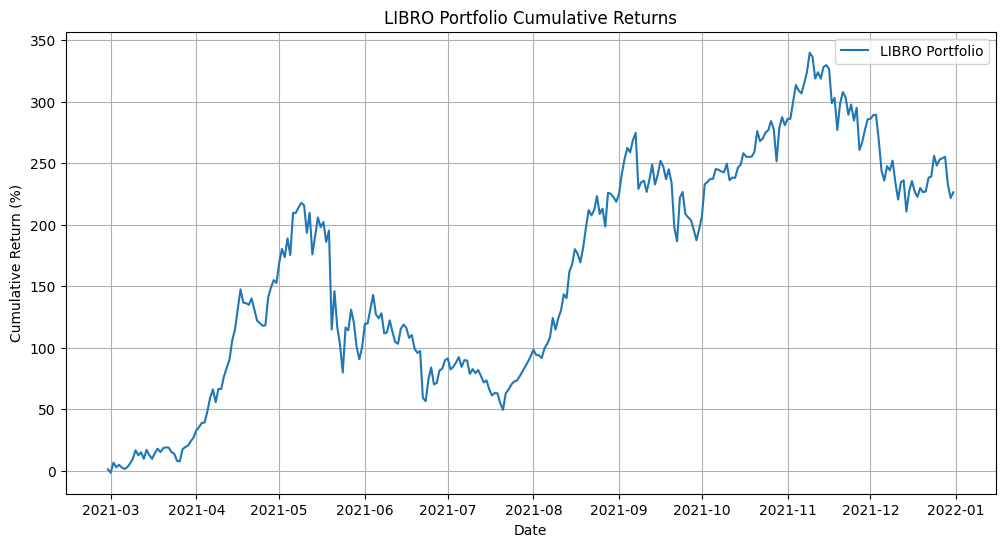

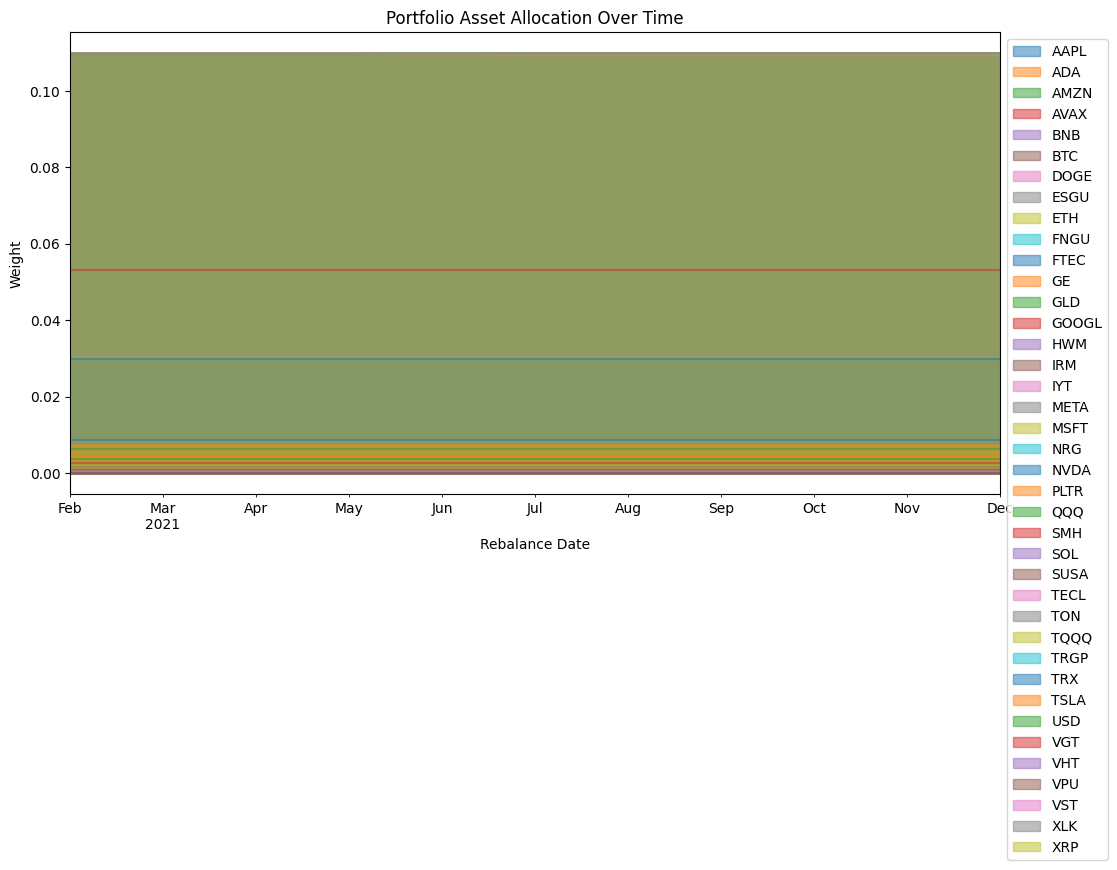

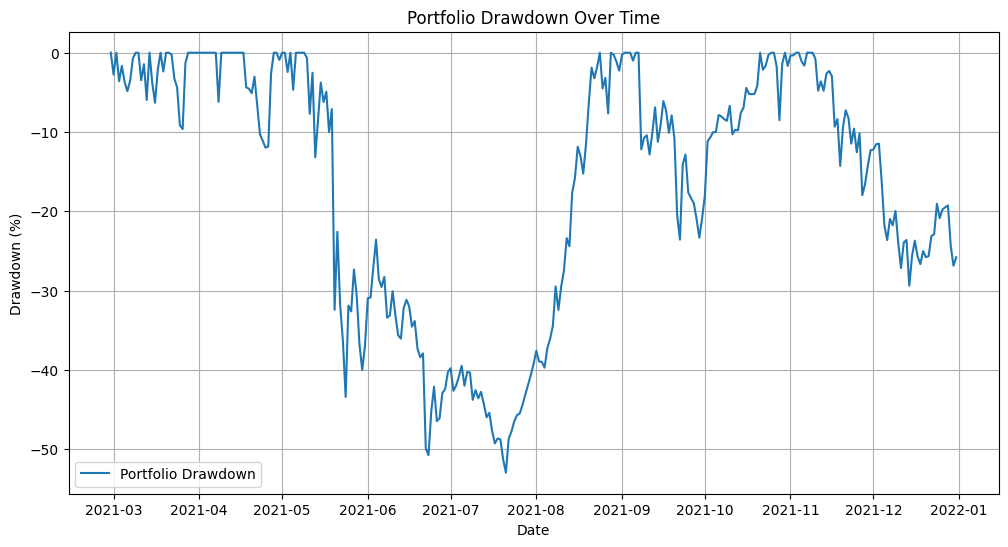

In [132]:
# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(portfolio_returns_df.index, portfolio_returns_df['cumulative_return'] * 100, label='LIBRO Portfolio')
plt.title('LIBRO Portfolio Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (%)')
plt.legend()
plt.grid(True)
plt.show()

# Plot asset weights over time
weights_df = pd.DataFrame(portfolio_weights).T
weights_df.index = pd.to_datetime(weights_df.index)
weights_df.sort_index(inplace=True)

weights_df.plot(kind='area', figsize=(12, 6), stacked=False)
plt.title('Portfolio Asset Allocation Over Time')
plt.xlabel('Rebalance Date')
plt.ylabel('Weight')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

# Assuming 'portfolio_returns_df' has been calculated
portfolio_returns_df['cumulative_return'] = (1 + portfolio_returns_df['portfolio_return']).cumprod()
rolling_max = portfolio_returns_df['cumulative_return'].cummax()
portfolio_returns_df['drawdown'] = (portfolio_returns_df['cumulative_return'] / rolling_max) - 1
plt.figure(figsize=(12, 6))
plt.plot(portfolio_returns_df.index, portfolio_returns_df['drawdown'] * 100, label='Portfolio Drawdown')
plt.title('Portfolio Drawdown Over Time')
plt.xlabel('Date')
plt.ylabel('Drawdown (%)')
plt.legend()
plt.grid(True)
plt.show()

In [134]:
# Read benchmark data (e.g., SPY)
"""benchmark_file = 'path_to_csv/SPY.csv'  # Replace with your file path
benchmark_df = read_asset_data(benchmark_file, 'SPY')
benchmark_df = calculate_returns(benchmark_df)
benchmark_df.set_index('date', inplace=True)
benchmark_df['cumulative_return'] = (1 + benchmark_df['return']).cumprod() - 1
# Align dates
common_dates = portfolio_returns_df.index.intersection(benchmark_df.index)

plt.figure(figsize=(12, 6))
plt.plot(portfolio_returns_df.loc[common_dates].index,
         portfolio_returns_df.loc[common_dates, 'cumulative_return'] * 100,
         label='LIBRO Portfolio')
plt.plot(benchmark_df.loc[common_dates].index,
         benchmark_df.loc[common_dates, 'cumulative_return'] * 100,
         label='Benchmark (SPY)')
plt.title('Portfolio vs. Benchmark Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (%)')
plt.legend()
plt.grid(True)
plt.show()

"""

SyntaxError: incomplete input (1339840004.py, line 2)